In [1]:
# imports

## allow interaction with the plots
%matplotlib widget

%load_ext autoreload
%autoreload 2

# add the main directory reference and import 'imports.py'
import sys
import os

if ".." not in sys.path:
    sys.path.insert(0, "..")
from imports import *

logger = logging.getLogger()
logger.setLevel(level=logging.WARN)

__builtins__.verbosity = 4
# Set the HF_HOME environment variable
os.environ["HF_HOME"] = "/run/media/HUNK/DATASETS/HF"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [3]:
# Declare a few global data/train params
from lib.optim import WarmupCosineLR
from data.pgnSeq import *

from extras.train import SeqTrainer


class params:
    num_workers = 24
    # batch_size = 160
    batch_size = 64
    seq_len = 140
    files_per_epoch = 800

    max_epochs = 200
    # lr = 0.005
    lr = 0.005

    flush_epoch_units = False
    loss_every = 100


dt = PGNData(
    PGNDataConfig.create(
        params, directory="resources/lichess_elite", files_per_epoch=100
    )
)

# dt.preview()

number of parameters: 91.04M
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(7797, 768)
    (wpe): Embedding(140, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=7797, bias=False)
)
funcname = _load_previous - GPT__seq_len

/ARCHIVE/Personal/2186474940/lib/train.py:623: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print("Found older file:", files[-1])


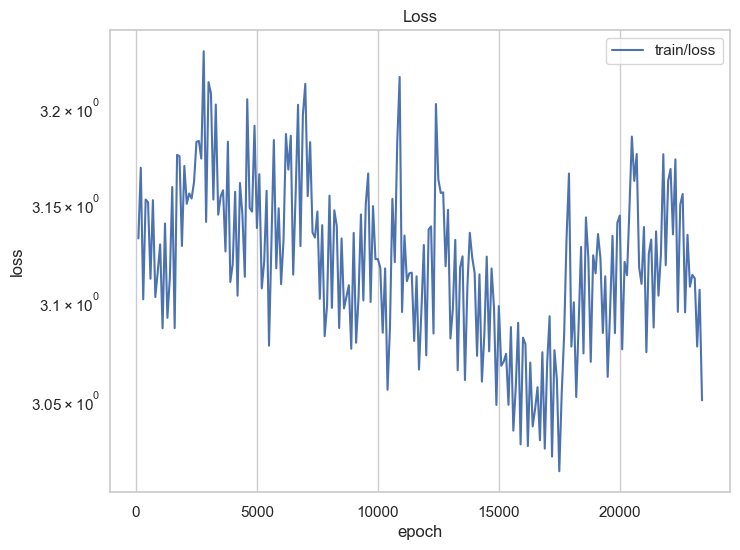

Epochs progress:   0%|          | 0/200 [00:00<?, ?Epoch/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78c3731c39c0>
Traceback (most recent call last):
  File "/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78c3731c39c0>
Traceback (most recent call last):
  File "/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1105996/2419388360.py", line 22, in <module>
    trainer.fit(model, dt.loaders())
  File "/ARCHIVE/Personal/2186474940/lib/train.py", line 296, in fit
  File "/ARCHIVE/Personal/2186474940/lib/train.py", line 331, in _fit_epoch
    self.model.train()
                ^^^^^^^
  File "/tmp/ipykernel_1105996/311485605.py", line 29, in prepare_batch
    batch = batch[0].to(self.device)
            ^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 2142, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          

In [10]:
# train nanogpt
from models.nanoGPT import *


model = GPT(
    GPTConfig(
        vocab_size=dt.classes,
        bias=True,
        seq_len=params.seq_len,
    )
)

print(model)
trainer = SeqTrainer(
    TrainerConfig.create(
        params,
        epoch_end_callback=dt.shuffle_files,
        save_model_every=20,
        load_previous="relaxed",
    )
)

trainer.fit(model, dt.loaders())


In [8]:
trainer._save_model()

number of parameters: 91.13M
RWKV(
  (transformer): ModuleDict(
    (wte): Embedding(7797, 768)
    (wpe): Embedding(140, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (tmix): RWKV_TimeMix_x051a(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (receptance): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (gate): Linear(in_features=768, out_features=768, bias=True)
          (output): Linear(in_features=768, out_features=768, bias=True)
          (ln_x): GroupNorm(12, 768, eps=0.00064, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (cmix): RWKV_ChannelMix_x051a(
          (time_shift): ZeroPad2d((0, 0, 1, -1))
          (key): Linear(in_features=768, out_features=2304, bias=Tru

/ARCHIVE/Personal/2186474940/lib/train.py:576: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


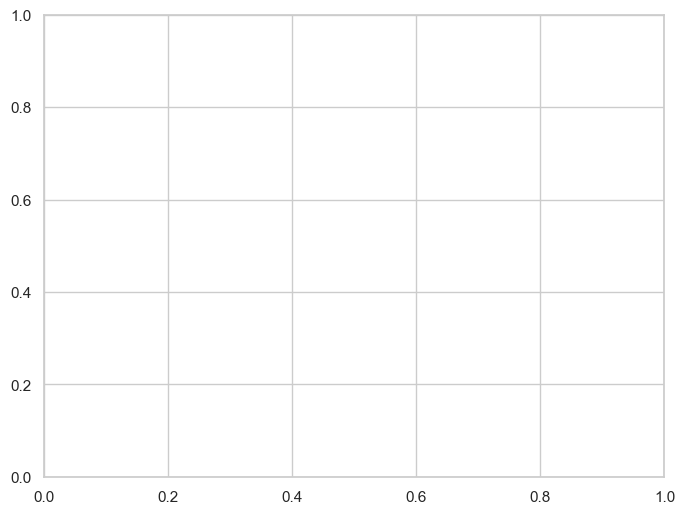

Epochs progress:   0%|          | 0/200 [00:00<?, ?Epoch/s]

/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  self.pid = os.fork()
/ARCHIVE/Personal/2186474940/.pixi/envs/dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and 

KeyboardInterrupt: 

In [4]:
# train rwkv

from models.nanoRWKV import *


model = RWKV(
    GPTConfig(
        vocab_size=dt.classes,
        bias=True,
        seq_len=params.seq_len,
    )
)
# model = RWKV(RWKVConfig(vocab_size=dt.classes, bias=True, seq_len=params.seq_len))

print(model)
trainer = SeqTrainer(
    TrainerConfig.create(
        params,
        epoch_end_callback=dt.shuffle_files,
        save_model_every=5,
        load_previous=True,
    )
)

trainer.fit(model, dt.loaders())
